### XGBoost
--------------
변경사항
- 1) current_date
- 2) outcome_name ; 변경하면서 다시 재실행 
--------------

In [1]:
current_date = 20220317
# outcome_list=['meloxicam', 'celecoxib', 'valproic_acid, lamotrigine']
outcome_name = 'meloxicam' 
domains = ['measurement', 'drug', 'procedure', 'condition']

In [2]:
import os
import pathlib
current_dir = pathlib.Path.cwd()
parent_dir = current_dir.parent
data_dir = pathlib.Path('{}/data/{}/preprocess/{}/'.format(parent_dir, current_date, outcome_name))
output_result_dir = pathlib.Path('{}/result/{}/xgboost/{}/'.format(parent_dir, current_date, outcome_name))
pathlib.Path.mkdir(output_result_dir, mode=0o777, parents=True, exist_ok=True)

file_list = os.listdir(data_dir)
file_list = [pathlib.Path(filename).with_suffix('').name for filename in file_list]
file_list

['meloxicam']

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from model_estimation import *

concat_df = pd.read_csv('{}/{}.txt'.format(data_dir, file_list[0]), index_col=False)

concat_df['cohort_start_date'] = pd.to_datetime(concat_df['cohort_start_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
concat_df['first_abnormal_date'] = pd.to_datetime(concat_df['first_abnormal_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
concat_df['concept_date'] = pd.to_datetime(concat_df['concept_date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    
# concat_df['duration'] = (concat_df['concept_date']-concat_df['cohort_start_date']).dt.days+1
concat_df = concat_df.drop(['person_id', 'cohort_start_date', 'concept_date', 'first_abnormal_date'], axis=1)

### @change column name ; column에 json파일 구분자가 들어가면 plot을 그리지 못함. 
import re
concat_df.columns = concat_df.columns.str.translate("".maketrans({"[":"(", "]":")"}))
concat_df = concat_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_ /()]+', '', x))
concat_df.columns

### @환자수 확인
print("label_1 : ",len(concat_df[concat_df["label"] == 1]))
print("label_0 : ",len(concat_df[concat_df["label"] == 0]))

### @x, y데이터 분할 
def split_x_y_data(df) :
    y_data = df['label'].T.reset_index(drop=True) 
    x_data = df.drop('label', axis=1)
    new_col = x_data.columns
    return x_data, y_data, new_col

x_data, y_data, new_col = split_x_y_data(concat_df)

### @train/test dataset 구분 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, stratify=y_data)

print("data  : ", x_data.shape, y_data.shape)
print("train : ", x_train.shape, y_train.shape)
print("test  : ", x_test.shape, y_test.shape)

label_1 :  101
label_0 :  6740
data  :  (6841, 47) (6841,)
train :  (4788, 47) (4788,)
test  :  (2053, 47) (2053,)


[0]	train-logloss:0.60101	eval-logloss:0.60149
[1]	train-logloss:0.52554	eval-logloss:0.52671
[2]	train-logloss:0.46259	eval-logloss:0.46429
[3]	train-logloss:0.40940	eval-logloss:0.41144
[4]	train-logloss:0.36385	eval-logloss:0.36645
[5]	train-logloss:0.32464	eval-logloss:0.32770
[6]	train-logloss:0.29061	eval-logloss:0.29411
[7]	train-logloss:0.26093	eval-logloss:0.26479
[8]	train-logloss:0.23487	eval-logloss:0.23919
[9]	train-logloss:0.21179	eval-logloss:0.21689
[10]	train-logloss:0.19153	eval-logloss:0.19742
[11]	train-logloss:0.17355	eval-logloss:0.18012
[12]	train-logloss:0.15766	eval-logloss:0.16496
[13]	train-logloss:0.14347	eval-logloss:0.15138
[14]	train-logloss:0.13083	eval-logloss:0.13940
[15]	train-logloss:0.11958	eval-logloss:0.12871
[16]	train-logloss:0.10942	eval-logloss:0.11889
[17]	train-logloss:0.10035	eval-logloss:0.11008
[18]	train-logloss:0.09217	eval-logloss:0.10225
[19]	train-logloss:0.08483	eval-logloss:0.09534
[20]	train-logloss:0.07823	eval-logloss:0.08907
[2

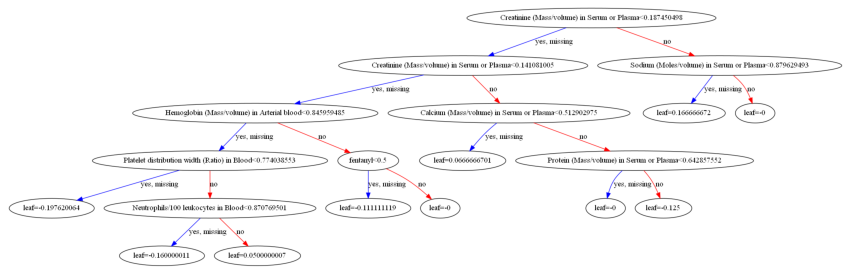

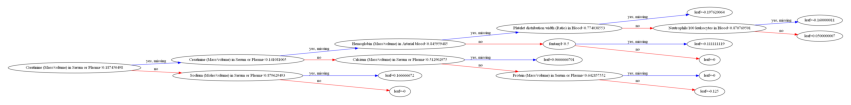

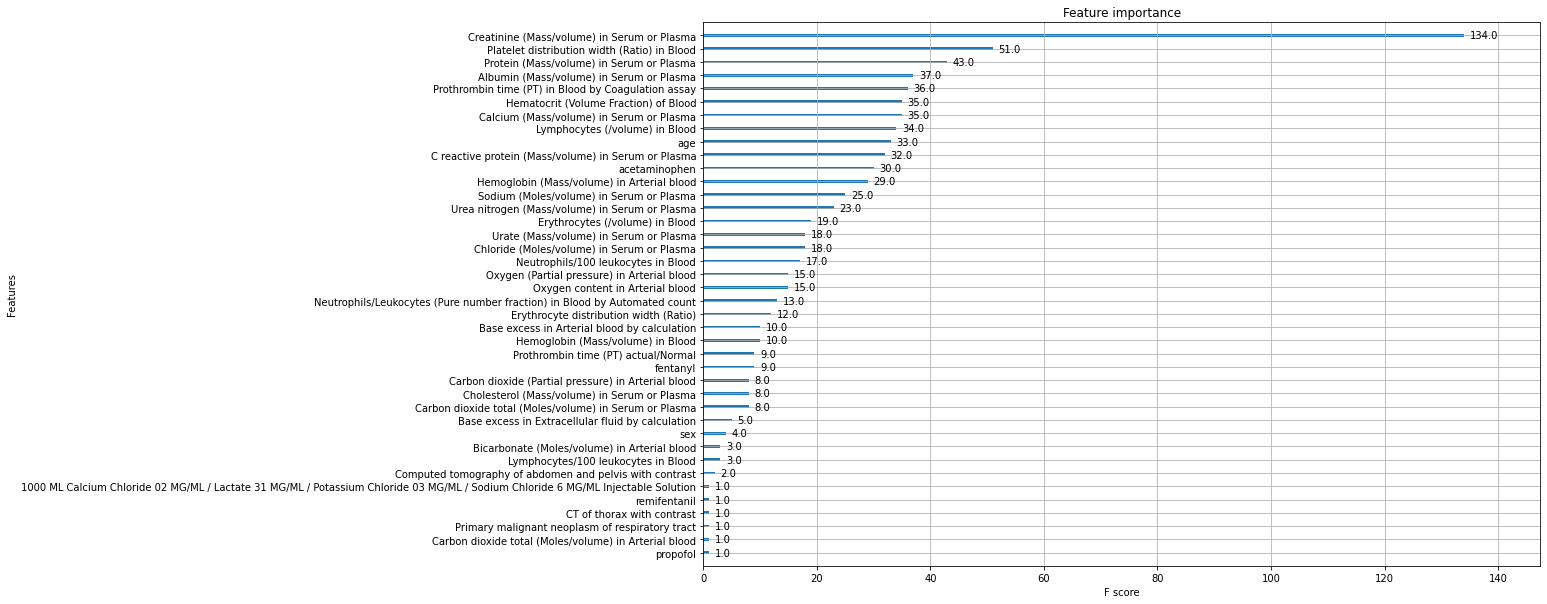

              precision    recall  f1-score   support

     label 0       0.99      1.00      0.99      2023
     label 1       0.70      0.53      0.60        30

    accuracy                           0.99      2053
   macro avg       0.84      0.76      0.80      2053
weighted avg       0.99      0.99      0.99      2053

TP 16
TN 2016
FP 14
FN 7
precision 53.333%
specificity 99.310%
accuracy 98.977%
recall 69.565%
f1_score 60.377%
roc_auc 88.169%
Normalized confusion matrix
[[0.99310345 0.00689655]
 [0.30434783 0.69565217]]
AUC: 0.8444
ACC: 98.977
{'learner': {'generic_param': {'fail_on_invalid_gpu_id': '0', 'gpu_id': '-1', 'n_jobs': '6', 'nthread': '6', 'random_state': '0', 'seed': '0', 'seed_per_iteration': '0', 'validate_parameters': '1'}, 'gradient_booster': {'gbtree_train_param': {'num_parallel_tree': '1', 'predictor': 'auto', 'process_type': 'default', 'tree_method': 'exact', 'updater': 'grow_colmaker,prune', 'updater_seq': 'grow_colmaker,prune'}, 'name': 'gbtree', 'specified

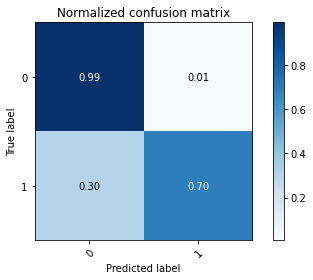

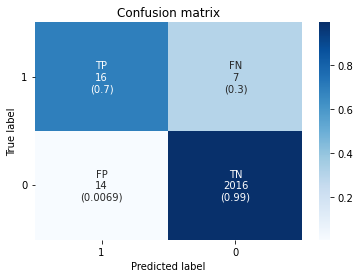

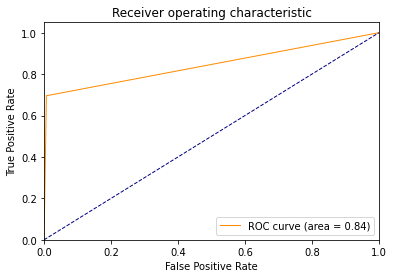

In [4]:
dtrain = xgb.DMatrix(data=x_train , label=y_train) 
dtest = xgb.DMatrix(data=x_test , label=y_test)

params = { 'max_depth':5, 'learning_rate': 0.1, 'objective':'binary:logistic', 'eval_metric':'logloss' }
num_rounds = 50
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달 
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=200, evals=wlist )
pred_probs = xgb_model.predict(dtest)

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds 에 저장
y_pred = [ 1 if x >= 0.5 else 0 for x in pred_probs ]
get_clf_eval(y_test, y_pred, pred_probs)

### @ save : plot tree & plot importance feature 
make_plot_tree(xgb_model, output_result_dir, outcome_name, rankdir=None)
make_plot_tree(xgb_model, output_result_dir, outcome_name, rankdir='LR')
make_plot_importance(xgb_model, output_result_dir, outcome_name)

### @ save : clf report & model estimation & confusion matrix & roc
clf_report(y_test, y_pred, output_result_dir, outcome_name)
model_performance_evaluation(y_test, y_pred, pred_probs, output_result_dir, outcome_name)
confusion_matrix_figure(y_test, y_pred, output_result_dir, outcome_name)
confusion_matrix_figure2(y_test, y_pred, output_result_dir, outcome_name)
AUC, ACC = ROC_AUC(y_test, y_pred, output_result_dir, outcome_name)

### @ save : model json
save_xgb_model_json(xgb_model, output_result_dir, outcome_name)

In [5]:
# from lightgbm import LGBMClassifier, plot_importance

# def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
#     model.fit(ftr_train, tgt_train)
#     pred = model.predict(ftr_test)
#     pred_proba = model.predict_proba(ftr_test)[:, 1]
#     get_clf_eval(tgt_test, pred, pred_proba)
        
#     fig, ax = plt.subplots(figsize=(10,12))
#     plot_importance(model, ax=ax)
#     plt.show()
    
# lgbm_clf = LGBMClassifier(n_estimators=400, num_leaves=10, n_jobs=-1, boost_from_average=False)
# get_model_train_eval(lgbm_clf, ftr_train=x_train, ftr_test=x_test, tgt_train=y_train, tgt_test=y_test)

In [6]:
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)

# xg_reg.fit(x_train,y_train)

# pred_probs = xg_reg.predict(x_test)     

# rmse = np.sqrt(mean_squared_error(y_test, pred_probs))
# print("RMSE: %f" % (rmse))

# # 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds 에 저장
# y_pred = [ 1 if x > 0.5 else 0 for x in pred_probs ]

# data_dmatrix = xgb.DMatrix(data=x_data,label=y_data)

# params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}
                
# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
                    
# cv_results.head()
# print((cv_results["test-rmse-mean"]).tail(1))

# xgb_model = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100)

# make_plot_tree(xgb_model, output_result_dir, outcome_name, rankdir=None)
# make_plot_tree(xgb_model, output_result_dir, outcome_name, rankdir='LR')
# make_plot_importance(xgb_model, output_result_dir, outcome_name)

# clf_report(y_test, y_pred, output_result_dir, outcome_name)
# model_performance_evaluation(y_test, y_pred, pred_probs, output_result_dir, outcome_name)
# confusion_matrix_figure(y_test, y_pred, output_result_dir, outcome_name)
# confusion_matrix_figure2(y_test, y_pred, output_result_dir, outcome_name)
# AUC, ACC = ROC_AUC(y_test, y_pred, output_result_dir, outcome_name)